In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context="talk")
pd.set_option('display.max_columns', 500)

from keplergl import KeplerGl
from haversine import haversine, Unit



from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


In [94]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])


    return trip_data

def set_dataset_absolute(data, X_column, group_by):
    weather = pd.DataFrame()
    weather[X_column] = data.groupby(group_by)[X_column].mean()
    weather["number_ids"]= data.groupby(group_by)["b_number"].count()
    return weather



Text(0, 0.5, 'Mean squared error')

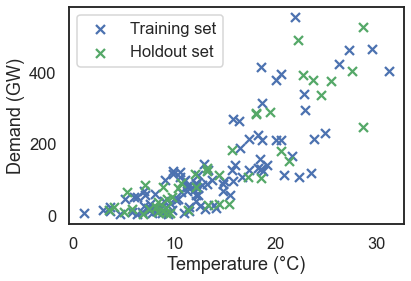

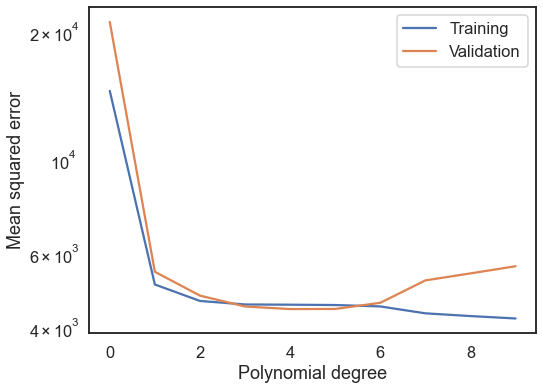

In [127]:
df = read_data("duesseldorf")
#df2 = read_data("bremen")
#df = df.append(df2)
test = set_dataset_absolute(df, "temp", "day")

xa = test["temp"]
ya = test["number_ids"]




# train-test split
X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3,random_state=42 )

plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])

err_train = []
err_cv = []


# define loop 

for deg in range(10): # we want to loop across 0-50 degrees
    
    # create poly features
    poly_feat = PolynomialFeatures(degree = deg)
    
    X_train_poly = poly_feat.fit_transform(X_train.values.reshape(-1,1))
    X_test_poly = poly_feat.fit_transform(X_test.values.reshape(-1,1))
    
    
    # fit model
    
    lin_mod_poly = LinearRegression()
    lin_mod_poly.fit(X_train_poly,y_train)
    
    
    # compute errors
    
    err_train.append(mean_squared_error(lin_mod_poly.predict(X_train_poly),y_train))
    err_cv.append(mean_squared_error(lin_mod_poly.predict(X_test_poly),y_test))
    

plt.figure(figsize = (8,6))    
plt.semilogy(range(10), err_train, range(10), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")




In [128]:
def plot_Poly_regression(X,Y,d):
    from sklearn.model_selection import train_test_split


    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # hold out set
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)


    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand/Day")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.7288691227386296
[ 0.00000000e+00  1.90739962e+00 -5.67787564e-01  8.87922585e-02
 -1.90167357e-03]


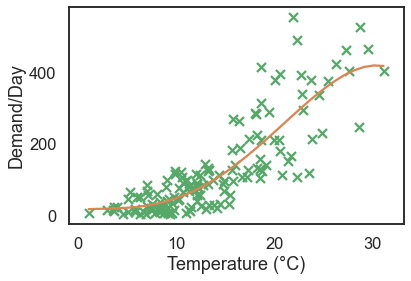

In [131]:
plot_Poly_regression(test["temp"].values,test["number_ids"].values,4)

In [130]:
df.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
0,0,2019-02-06,15:35:00,538,duesseldorf,0 days 00:17:00,51.218927,6.765862,51.240644,6.781982,2019-02-06 15:35:00,2019-02-06 15:52:00,2,2,15,6,2.662958,0.283333,9.398675,2019-02-06 16:00:00,9.5,5.0,0.0,51,131,15
1,1,2019-02-19,15:57:00,538,duesseldorf,0 days 00:23:00,51.213766,6.751624,51.223056,6.779230,2019-02-19 15:57:00,2019-02-19 16:20:00,1,2,15,8,2.182598,0.383333,5.693734,2019-02-19 16:00:00,10.3,5.6,0.0,69,131,16
2,2,2019-03-22,13:20:00,538,duesseldorf,0 days 01:20:00,51.229671,6.797855,51.218527,6.794867,2019-03-22 13:20:00,2019-03-22 14:40:00,4,3,13,12,1.256486,1.333333,0.942365,2019-03-22 13:00:00,19.0,3.5,0.0,120,235,38
3,3,2019-03-27,06:34:00,538,duesseldorf,0 days 00:22:00,51.218527,6.794867,51.252515,6.782041,2019-03-27 06:34:00,2019-03-27 06:56:00,2,3,6,13,3.883302,0.366667,10.590823,2019-03-27 07:00:00,4.8,0.5,0.0,164,235,34
4,4,2019-03-28,14:54:00,538,duesseldorf,0 days 00:12:00,51.252515,6.782041,51.242592,6.782100,2019-03-28 14:54:00,2019-03-28 15:06:00,3,3,14,13,1.103349,0.200000,5.516746,2019-03-28 15:00:00,12.5,1.7,0.0,164,235,36
